In [1]:
import torch
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
import numpy as np

from scipy.spatial.distance import cdist
from torch.nn import functional as F
import seaborn as sns

import flow_ssl
from flow_ssl.realnvp import RealNVP
from flow_ssl import FlowLoss
from tqdm import tqdm
from torch import distributions
import torch.nn as nn
import math

from flow_ssl.data import make_sup_data_loaders
from flow_ssl.invertible import SqueezeLayer

import cmocean.cm as cmo

from matplotlib import pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


### Loading model

In [1]:
img_shape = (1, 28, 28)
transform_train = transforms.Compose([
#     transforms.RandomCrop(28, padding=4),
    transforms.ToTensor()
])

transform_test = transforms.Compose([
    transforms.ToTensor()
])

data_path = "datasets/"

trainloader, testloader, _ = make_sup_data_loaders(
        data_path, 
        32, 
        4, 
        transform_train, 
        transform_test, 
        use_validation=False,
        shuffle_train=False,
        dataset="fashionmnist")

_, mnist_testloader, _ = make_sup_data_loaders(
        data_path, 
        32, 
        4, 
        transform_train, 
        transform_test, 
        use_validation=False,
        shuffle_train=False,
        dataset="mnist")


transform_notmnist = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor()
])

_, notmnist_testloader, _ = make_sup_data_loaders(
        data, 
        32, 
        4, 
        transform_notmnist, 
        transform_notmnist, 
        use_validation=False,
        shuffle_train=False,
        dataset="notmnist")

In [4]:
model_cfg = flow_ssl.Glow
net = model_cfg(image_shape=img_shape, mid_channels=200, num_scales=2,
               num_coupling_layers_per_scale=16, st_type='highway')
print("Model contains {} parameters".format(sum([p.numel() for p in net.parameters()])))
net = torch.nn.DataParallel(net, [0])

Model contains 69378048 parameters


In [5]:
net.load_state_dict(torch.load(
    "flow_ood/experiments/train_flows/ckpts/nips/"
    "glow/fashionmnist_scales2_ncl16_multiscale_highway_rmsprop/80.pt")["net"])
net.module.set_actnorm_init()
net.cuda();

In [2]:
# first forward pass before reverse
net.eval();
for x, _ in trainloader:
    net(x)
    break

In [7]:
class FlowLossList(nn.Module):
    def __init__(self, prior, k=256):
        super().__init__()
        self.k = k
        self.prior = prior

    def forward(self, z, sldj):
        z = z.reshape((z.shape[0], -1))
        prior_ll = self.prior.log_prob(z)
        corrected_prior_ll = prior_ll - np.log(self.k) * np.prod(z.size()[1:])
        ll = corrected_prior_ll + sldj
        return ll

In [8]:
def get_loss_vals(loss_fn, loader, net, testmode=True):
    if testmode:
        net.eval()
    else:
        net.train()
    loss_vals = []

    with torch.no_grad():
        with tqdm(total=len(loader.dataset)) as progress_bar:
            for x, _ in loader:
                x = x.cuda()
                z = net(x)
                sldj = net.module.logdet()
                
                losses = loss_fn(z, sldj=sldj)
                loss_vals.extend([loss.item() for loss in losses])

                progress_bar.update(x.size(0))
    return np.array(loss_vals)

In [9]:
from flow_ssl.invertible import iSequential, both, Id
from flow_ssl.realnvp.coupling_layer import CouplingLayer
from flow_ssl.invertible.downsample import iLogits
from flow_ssl.glow.glow_utils import InvertibleConv1x1, ActNorm2d

def get_reshape_model(img_shape, trainloader):
    reshape_model_ilogits = model_cfg(
        image_shape=img_shape, mid_channels=200, num_scales=2,
        num_coupling_layers_per_scale=16, st_type='highway')
    reshape_model_wo_ilogits = model_cfg(
        image_shape=img_shape, mid_channels=200, num_scales=2,
        num_coupling_layers_per_scale=16, st_type='highway')
    reshape_model_ilogits.cpu(); reshape_model_wo_ilogits.cpu();
    reshape_model_ilogits.eval(); reshape_model_wo_ilogits.eval();

    for m in reshape_model_ilogits.body._modules.values():
        if isinstance(m, iSequential):
            for subm in m._modules.values():
                if isinstance(subm, both):
                    if isinstance(subm.module1, CouplingLayer) or \
                        isinstance(subm.module1, InvertibleConv1x1) or\
                        isinstance(subm.module1, ActNorm2d):
                        subm.module1 = Id()
                    if isinstance(subm.module2, CouplingLayer) or \
                        isinstance(subm.module2, InvertibleConv1x1) or\
                        isinstance(subm.module2, ActNorm2d):
                        subm.module2 = Id()

    for m in reshape_model_wo_ilogits.body._modules.values():
        if isinstance(m, iSequential):
            for subm in m._modules.values():
                if isinstance(subm, both):
                    if isinstance(subm.module1, CouplingLayer) or \
                        isinstance(subm.module1, InvertibleConv1x1) or\
                        isinstance(subm.module1, ActNorm2d):
                        subm.module1 = Id()
                    if isinstance(subm.module2, CouplingLayer) or \
                        isinstance(subm.module2, InvertibleConv1x1) or\
                        isinstance(subm.module2, ActNorm2d):
                        subm.module2 = Id()
    
    # first foward pass before reverse
    for x, _ in trainloader:
        reshape_model_ilogits(x)
        reshape_model_wo_ilogits(x)
        break

    return reshape_model_ilogits, reshape_model_wo_ilogits

In [10]:
def draw_st_output(st_activation, x, idx=0):
    z = net(x)
    
    num_cols = len(cp_activation)
    f, axes = plt.subplots(4, num_cols//2, figsize=(16, 4), sharex=True, sharey=True)
    
    s_list = []
    t_list = []

    for k, (name, act) in enumerate(st_activation.items()):
        st = st_activation[name]
        i, j = [int(a) for a in name[6:].split('.')]
        
        # only works for less than 3 scales
        scales = st.shape[1] // 4
        s, t = st.chunk(2, dim=1)
        s = net.module.body[i][j].module1.rescale(torch.tanh(s))
        s = s.exp()

        for _ in range(scales):
            s = torch.cat((s, torch.ones_like(s)), 1)
            t = torch.cat((t, torch.zeros_like(t)), 1)
            sq_layer = SqueezeLayer(downscale_factor=2)
            s, t = sq_layer.inverse(s), sq_layer.inverse(t)

        s_ = s.cpu().detach().numpy()
        t_ = t.cpu().detach().numpy()
        s_list.append(s_)
        t_list.append(t_)


        axes[2*(k // (num_cols//2))][k % (num_cols//2)].imshow(s_[idx][0], cmap=cmo.ice)
        axes[2*(k // (num_cols//2)) + 1][k % (num_cols//2)].imshow(t_[idx][0], cmap=cmo.ice)
        
        axes[2*(k // (num_cols//2))][k % (num_cols//2)].set_xticks([]) 
        axes[2*(k // (num_cols//2))][k % (num_cols//2)].set_yticks([]) 
        axes[2*(k // (num_cols//2)) + 1][k % (num_cols//2)].set_xticks([]) 
        axes[2*(k // (num_cols//2)) + 1][k % (num_cols//2)].set_yticks([]) 
        axes[2*(k // (num_cols//2))][k % (num_cols//2)].set_title('{}.{}'.format(i, j)) 

    axes[0][0].set_ylabel('s', fontsize=20)
    axes[1][0].set_ylabel('t', fontsize=20)
    axes[2][0].set_ylabel('s', fontsize=20)
    axes[3][0].set_ylabel('t', fontsize=20)
    plt.tight_layout()
    
    return np.concatenate(s_list, axis=1), np.concatenate(t_list, axis=1)

In [11]:
def draw_coupling_layer(cp_activation, x, idx=0):
    z = net(x)
    num_cols = len(cp_activation)
    f, axes = plt.subplots(2, num_cols // 2, figsize=(16, 3), sharex=True, sharey=True)
    cp_list = []

    for k, (name, act) in enumerate(cp_activation.items()):
        cp = cp_activation[name]
        i, j = [int(a) for a in name[2:].split('.')]

        # only works for less than 3 scales
        scales = cp[0].shape[1] // 4
        res = cp[0]
        for t in range(scales):
            sq_layer = SqueezeLayer(downscale_factor=2)
            res = sq_layer.inverse(res)
            if res.shape[1] > 1:
                res = torch.cat((res, cp[-(t+1)]), 1)
    
        res_ = res.cpu().detach().numpy()
        cp_list.append(res_)
        f1 = axes[k // (num_cols//2)][k % (num_cols//2)].imshow(res_[idx][0], cmap=cmo.ice)

        axes[k // (num_cols//2)][k % (num_cols//2)].set_xticks([]) 
        axes[k // (num_cols//2)][k % (num_cols//2)].set_yticks([]) 
        axes[k // (num_cols//2)][k % (num_cols//2)].set_title('{}.{}'.format(i, j)) 

    plt.tight_layout()
    return np.concatenate(cp_list, axis=1)

In [12]:
D = 28 * 28
prior = distributions.MultivariateNormal(torch.zeros(D).cuda(),
                                         torch.eye(D).cuda())
flowlosslist_fn = FlowLossList(prior)

**<center><font size="6">Evaluation Mode</center>**

<h1><span style="color:black">Samples</span></h1>

In [13]:
def sample(net, prior, batch_size):
    with torch.no_grad():
        z = prior.sample((batch_size,))
        x = net.module.inverse(z)
        return x

In [16]:
x_sampled = sample(net, prior, 9)
x_sampled_np = x_sampled.cpu().detach().numpy()

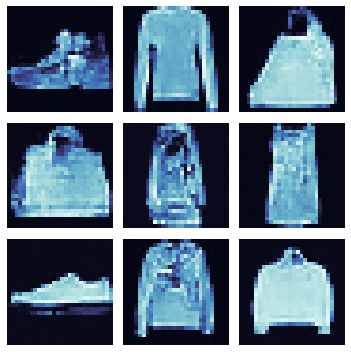

In [18]:
f, axes = plt.subplots(3, 3, figsize=(5, 5))
for i in range(9):
    axes[i//3][i%3].imshow(x_sampled_np[i][0], cmap=cmo.ice)
    axes[i//3][i%3].axis('off')

plt.tight_layout()
# plt.savefig("img_src/glow_fashion/samples.pdf", bbox_inches="tight")

In [19]:
# np.savez('img_src/glow_fashion/samples.npz', samples=x_sampled_np)

## Likelihoods in Eval Mode

In [20]:
sns.set_style('whitegrid')

In [21]:
net.eval();

In [22]:
train_loss_vals = get_loss_vals(flowlosslist_fn, trainloader, net)
train_bpd = -train_loss_vals.mean() / (np.log(2) * 28 * 28)
print(train_bpd)

100%|██████████| 60000/60000 [04:30<00:00, 221.98it/s]

3.102829874992886


In [23]:
test_loss_vals = get_loss_vals(flowlosslist_fn, testloader, net)
test_bpd = -test_loss_vals.mean() / (np.log(2) * 28 * 28)
print(test_bpd)

100%|██████████| 10000/10000 [00:45<00:00, 221.68it/s]

3.140785922709375


In [24]:
ood_loss_vals = get_loss_vals(flowlosslist_fn, mnist_testloader, net)
ood_bpd = -ood_loss_vals.mean() / (np.log(2) * 28 * 28)
print(ood_bpd)

100%|██████████| 10000/10000 [00:45<00:00, 220.05it/s]

2.0807301540304275


In [25]:
notmnist_loss_vals = get_loss_vals(flowlosslist_fn, notmnist_testloader, net)
notmnist_bpd = -notmnist_loss_vals.mean() / (np.log(2) * 28 * 28)
print(notmnist_bpd)

100%|██████████| 18724/18724 [01:22<00:00, 226.48it/s]

4.064705864382526


In [28]:
# np.savez('img_src/glow_fashion/likelihoods.npz',
#          fashion_train=train_loss_vals, fashion_test=test_loss_vals,
#          mnist=ood_loss_vals, notmnist=notmnist_loss_vals)

2 outliers
0 outliers
0 outliers
0 outliers


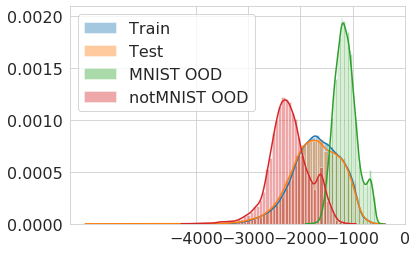

In [27]:
def filter_threshold(llarray, threshold):
    print(np.sum(llarray < threshold), "outliers")
    return llarray[llarray > threshold]

sns.distplot(filter_threshold(train_loss_vals, -10000), label="Train")
sns.distplot(filter_threshold(test_loss_vals, -10000), label="Test")
sns.distplot(filter_threshold(ood_loss_vals, -10000), label="MNIST OOD")
sns.distplot(filter_threshold(notmnist_loss_vals, -10000), label="notMNIST OOD")
# plt.xlim(-5000, 5000)
plt.xticks(np.linspace(-4000, 0, 5), fontsize=16)
plt.yticks(np.linspace(0., 0.002, 5), fontsize=16)
plt.legend(fontsize=16)
# plt.savefig("img_src/glow_fashion/likelihoods.pdf", bbox_inches="tight")

<h1><span style="color:red">Jacobian and Latent distribution likelihoods</span></h1>

<h1><span style="color:red">BatchNorm statistics</span></h1>

<h1><span style="color:black">st-network outputs & per-coupling-layer-visualizations</span></h1>

Model structure

In [42]:
for i, m in enumerate(net.module.body._modules.values()):
    print(i, type(m))
    if isinstance(m, iSequential):
        for subm in m._modules.values():
            print('\t', type(subm))
            if isinstance(subm, both):
                print('\t\t', type(subm.module1))
                print('\t\t', type(subm.module2))
    
    if i > 5:
        print('...')
        break

0 <class 'flow_ssl.invertible.parts.addZslot'>
1 <class 'flow_ssl.invertible.parts.iSequential'>
	 <class 'flow_ssl.invertible.parts.both'>
		 <class 'flow_ssl.invertible.downsample.iLogits'>
		 <class 'flow_ssl.invertible.parts.Id'>
2 <class 'flow_ssl.invertible.parts.iSequential'>
	 <class 'flow_ssl.invertible.parts.both'>
		 <class 'flow_ssl.invertible.downsample.SqueezeLayer'>
		 <class 'flow_ssl.invertible.parts.Id'>
3 <class 'flow_ssl.invertible.parts.iSequential'>
	 <class 'flow_ssl.invertible.parts.both'>
		 <class 'flow_ssl.glow.glow_utils.ActNorm2d'>
		 <class 'flow_ssl.invertible.parts.Id'>
	 <class 'flow_ssl.invertible.parts.both'>
		 <class 'flow_ssl.glow.glow_utils.InvertibleConv1x1'>
		 <class 'flow_ssl.invertible.parts.Id'>
	 <class 'flow_ssl.invertible.parts.both'>
		 <class 'flow_ssl.realnvp.coupling_layer.CouplingLayer'>
		 <class 'flow_ssl.invertible.parts.Id'>
4 <class 'flow_ssl.invertible.parts.iSequential'>
	 <class 'flow_ssl.invertible.parts.both'>
		 <class 'fl

Coupling Layers

In [38]:
for i, m in enumerate(net.module.body._modules.values()):
    if isinstance(m, iSequential):
        for subm in m._modules.values():
            if isinstance(subm, both):
                if isinstance(subm.module1, CouplingLayer):
                    print(i, type(subm.module1.st_net))
                if isinstance(subm.module2, CouplingLayer):
                    print(i, type(subm.module2.st_net))

In [13]:
# Register forward hooks to save intermediate output

st_activation = {}
def get_st_activation(name):
    def hook(model, input, output):
        st_activation[name] = output.detach()
    return hook


cp_activation = {}
def get_cp_activation(name):
    def hook(model, input, output):
        res = [output[0].detach()]
        if len(output[1]):
            res.append(output[1][0].detach())
        cp_activation[name] = res
    return hook


for i in range(len(net.module.body)):
    if not isinstance(net.module.body[i], iSequential): continue

    for j in range(len(net.module.body[i])):
        if not isinstance(net.module.body[i][j], both): continue
        
        if isinstance(net.module.body[i][j].module1, CouplingLayer) or\
                 isinstance(net.module.body[i][j].module2, CouplingLayer):
            net.module.body[i][j].register_forward_hook(get_cp_activation('cp{}.{}'.format(i, j)))

        if isinstance(net.module.body[i][j].module1, CouplingLayer):
            net.module.body[i][j].module1.st_net.register_forward_hook(
                get_st_activation('st_net{}.{}'.format(i, j)))

        if isinstance(net.module.body[i][j].module2, CouplingLayer):
            net.module.body[i][j].module2.st_net.register_forward_hook(
                get_st_activation('st_net{}.{}'.format(i, j)))

In [24]:
for x, _ in testloader:
    break

In [25]:
z = net(x)

In [16]:
for name, act in st_activation.items():
    print(name, act.shape)

st_net3.2 torch.Size([32, 4, 14, 14])
st_net4.2 torch.Size([32, 4, 14, 14])
st_net5.2 torch.Size([32, 4, 14, 14])
st_net6.2 torch.Size([32, 4, 14, 14])
st_net7.2 torch.Size([32, 4, 14, 14])
st_net8.2 torch.Size([32, 4, 14, 14])
st_net9.2 torch.Size([32, 4, 14, 14])
st_net10.2 torch.Size([32, 4, 14, 14])
st_net11.2 torch.Size([32, 4, 14, 14])
st_net12.2 torch.Size([32, 4, 14, 14])
st_net13.2 torch.Size([32, 4, 14, 14])
st_net14.2 torch.Size([32, 4, 14, 14])
st_net15.2 torch.Size([32, 4, 14, 14])
st_net16.2 torch.Size([32, 4, 14, 14])
st_net17.2 torch.Size([32, 4, 14, 14])
st_net18.2 torch.Size([32, 4, 14, 14])
st_net21.2 torch.Size([32, 8, 7, 7])
st_net22.2 torch.Size([32, 8, 7, 7])
st_net23.2 torch.Size([32, 8, 7, 7])
st_net24.2 torch.Size([32, 8, 7, 7])
st_net25.2 torch.Size([32, 8, 7, 7])
st_net26.2 torch.Size([32, 8, 7, 7])
st_net27.2 torch.Size([32, 8, 7, 7])
st_net28.2 torch.Size([32, 8, 7, 7])
st_net29.2 torch.Size([32, 8, 7, 7])
st_net30.2 torch.Size([32, 8, 7, 7])
st_net31.2 to

In [17]:
for name, act in cp_activation.items():
    print(name, *[a.shape for a in act])

cp3.2 torch.Size([32, 4, 14, 14])
cp4.2 torch.Size([32, 4, 14, 14])
cp5.2 torch.Size([32, 4, 14, 14])
cp6.2 torch.Size([32, 4, 14, 14])
cp7.2 torch.Size([32, 4, 14, 14])
cp8.2 torch.Size([32, 4, 14, 14])
cp9.2 torch.Size([32, 4, 14, 14])
cp10.2 torch.Size([32, 4, 14, 14])
cp11.2 torch.Size([32, 4, 14, 14])
cp12.2 torch.Size([32, 4, 14, 14])
cp13.2 torch.Size([32, 4, 14, 14])
cp14.2 torch.Size([32, 4, 14, 14])
cp15.2 torch.Size([32, 4, 14, 14])
cp16.2 torch.Size([32, 4, 14, 14])
cp17.2 torch.Size([32, 4, 14, 14])
cp18.2 torch.Size([32, 4, 14, 14])
cp21.2 torch.Size([32, 8, 7, 7]) torch.Size([32, 2, 14, 14])
cp22.2 torch.Size([32, 8, 7, 7]) torch.Size([32, 2, 14, 14])
cp23.2 torch.Size([32, 8, 7, 7]) torch.Size([32, 2, 14, 14])
cp24.2 torch.Size([32, 8, 7, 7]) torch.Size([32, 2, 14, 14])
cp25.2 torch.Size([32, 8, 7, 7]) torch.Size([32, 2, 14, 14])
cp26.2 torch.Size([32, 8, 7, 7]) torch.Size([32, 2, 14, 14])
cp27.2 torch.Size([32, 8, 7, 7]) torch.Size([32, 2, 14, 14])
cp28.2 torch.Size([3

### In-distribution

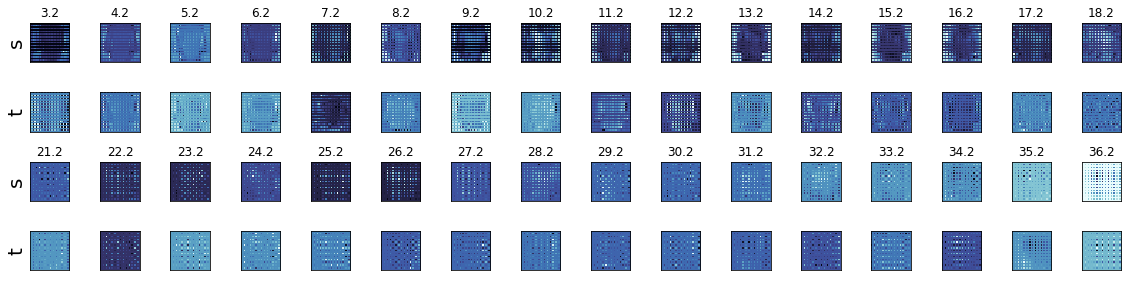

In [26]:
slist, tlist = draw_st_output(st_activation, x, idx=4)

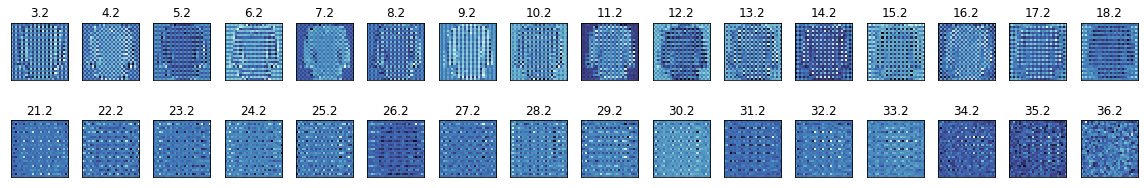

In [27]:
cplist = draw_coupling_layer(cp_activation, x, idx=4)

In [28]:
slist.shape, tlist.shape, cplist.shape

((32, 32, 28, 28), (32, 32, 28, 28), (32, 32, 28, 28))

In [29]:
# np.savez('img_src/glow_fashion/fashion_st_coupling.npz',
#          x=x.cpu().numpy(), s=slist, t=tlist, coupling=cplist)

### Out-of-distribution

In [30]:
for x, _ in mnist_testloader:
    break

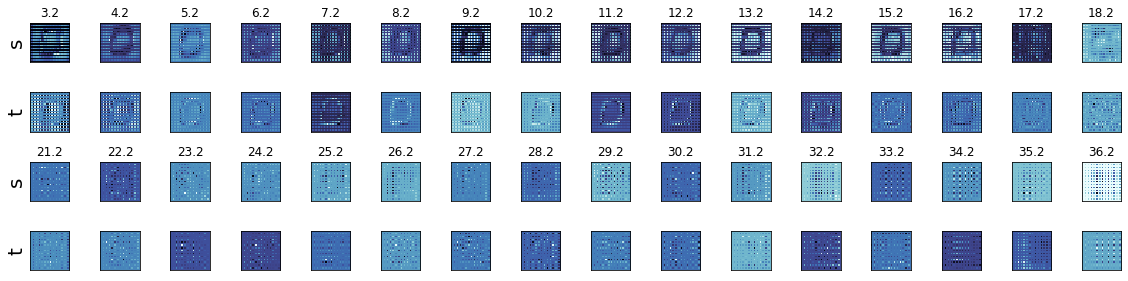

In [31]:
slist, tlist = draw_st_output(st_activation, x, idx=10)

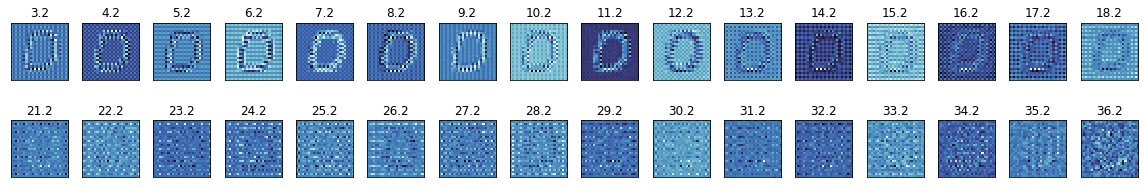

In [32]:
cplist = draw_coupling_layer(cp_activation, x, idx=10)

In [33]:
slist.shape, tlist.shape, cplist.shape

((32, 32, 28, 28), (32, 32, 28, 28), (32, 32, 28, 28))

In [34]:
# np.savez('img_src/glow_fashion/mnist_st_coupling.npz',
#          x=x.cpu().numpy(), s=slist, t=tlist, coupling=cplist)

# Z-space visualizations

In [59]:
reshape_model_ilogits, reshape_model_wo_ilogits = get_reshape_model(img_shape, trainloader)

In [60]:
net.eval();

flowlosslist_fn = FlowLossList(prior)

[-1938.177734375, -717.3818359375, -1230.21826171875, -975.1572265625, -1666.47216796875, -1419.50048828125, -1554.448486328125, -2166.09619140625, -1530.183837890625]


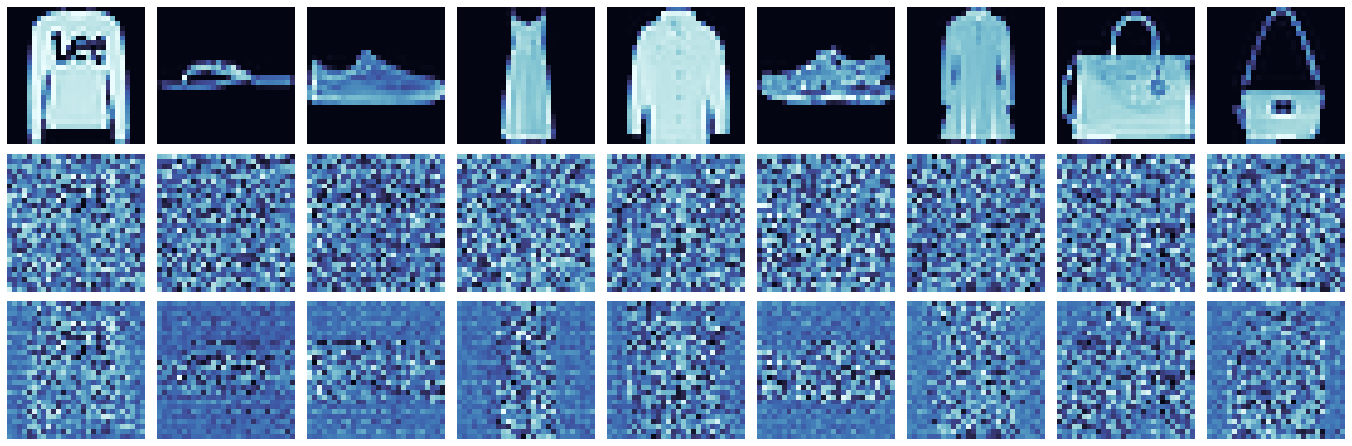

In [62]:
img_idx = [1, 8, 12, 13, 14, 21, 29, 30, 31]

# Test mode

net.eval()
for x, _ in testloader:
    break
with torch.no_grad():
    z = net(x)
    sldj = net.module.logdet()
    lls = flowlosslist_fn(z, sldj)

z_reshaped = reshape_model_wo_ilogits.inverse(z).detach().cpu().numpy()


# Latent avg
z_dequantized = []
for _ in range(40):
    z = net(x)
    z_dequantized.append(z.detach().cpu())

zs = torch.stack(z_dequantized, dim=1)
z_avg = reshape_model_wo_ilogits.inverse(zs.mean(dim=1)).numpy()

x_ = x.detach().cpu().numpy()

nrows, ncols = 3, len(img_idx)
fig, arr = plt.subplots(nrows, ncols, figsize=(ncols*2.1, nrows*2.1))
    
for i, idx in enumerate(img_idx):
    arr[0, i].imshow(x_[idx][0], cmap=cmo.ice)
    arr[1, i].imshow(z_reshaped[idx][0], cmap=cmo.ice)
    arr[2, i].imshow(z_avg[idx][0], cmap=cmo.ice)
    arr[0, i].axis('off')
    arr[1, i].axis('off')
    arr[2, i].axis('off')

print([lls[idx].item() for idx in img_idx])
plt.tight_layout()

# plt.savefig("img_src/glow_fashion/fashion_appendix_latent_space.pdf", bbox_inches='tight')

In [64]:
# np.savez('img_src/glow_fashion/fashion_appendix_latent_space.npz',
#          x=x_[img_idx], z=z_reshaped[img_idx], z_avg=z_avg[img_idx])

[-1258.3984375, -1250.46826171875, -1054.1767578125, -1251.53955078125, -674.9384765625, -1050.25, -641.15185546875, -1089.5380859375, -635.685546875]


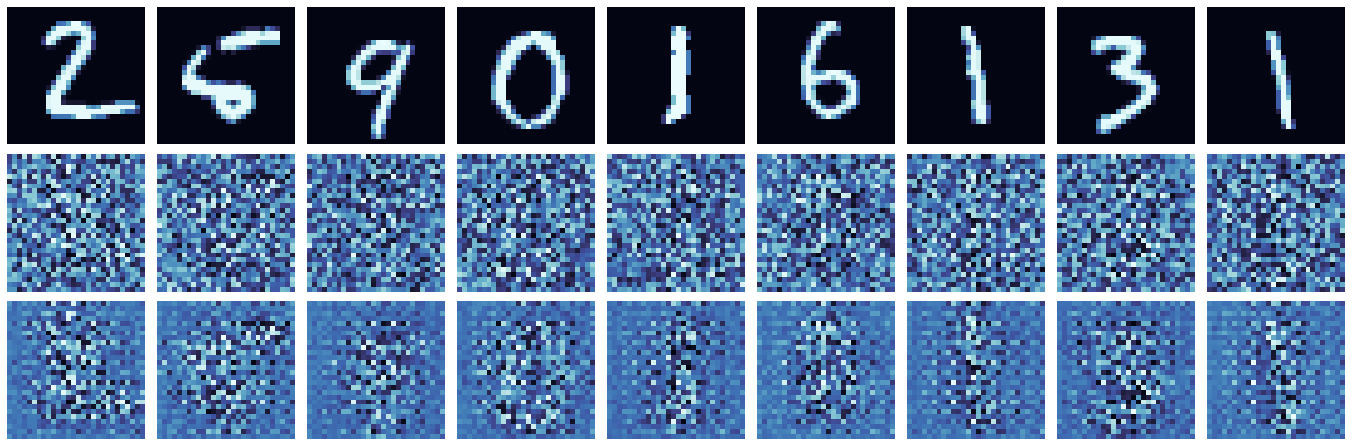

In [65]:
img_idx = [1, 8, 12, 13, 14, 21, 29, 30, 31]

# Test mode

net.eval()
for x, _ in mnist_testloader:
    break
with torch.no_grad():
    z = net(x)
    sldj = net.module.logdet()
    lls = flowlosslist_fn(z, sldj)

z_reshaped = reshape_model_wo_ilogits.inverse(z).detach().cpu().numpy()


# Latent avg
z_dequantized = []
for _ in range(40):
    z = net(x)
    z_dequantized.append(z.detach().cpu())

zs = torch.stack(z_dequantized, dim=1)
z_avg = reshape_model_wo_ilogits.inverse(zs.mean(dim=1)).numpy()

x_ = x.detach().cpu().numpy()


nrows, ncols = 3, len(img_idx)
fig, arr = plt.subplots(nrows, ncols, figsize=(ncols*2.1, nrows*2.1))
    
for i, idx in enumerate(img_idx):
    arr[0, i].imshow(x_[idx][0], cmap=cmo.ice)
    arr[1, i].imshow(z_reshaped[idx][0], cmap=cmo.ice)
    arr[2, i].imshow(z_avg[idx][0], cmap=cmo.ice)
    arr[0, i].axis('off')
    arr[1, i].axis('off')
    arr[2, i].axis('off')

print([lls[idx].item() for idx in img_idx])
plt.tight_layout()

# plt.savefig("img_src/realnvp_fashion/mnist_appendix_latent_space.pdf", bbox_inches='tight')

In [66]:
# np.savez('img_src/glow_fashion/mnist_appendix_latent_space.npz',
#          x=x_[img_idx], z=z_reshaped[img_idx], z_avg=z_avg[img_idx])